### Model-Based Agent: Exploration of the Martian Lava Tubes

In [ ]:
%%capture
!pip install minigrid gymnasium matplotlib numpy


Starting Mission 1...
Mission 1 Result: ❌ FAILED
  Steps taken: 196
  Goal located at: (5, 21)

Starting Mission 2...
Mission 2 Result: ❌ FAILED
  Steps taken: 196
  Goal located at: (0, 54)

Starting Mission 3...
Mission 3 Result: ❌ FAILED
  Steps taken: 196
  Goal located at: (0, 38)

FINAL INTERNAL MAP VISUALIZATION


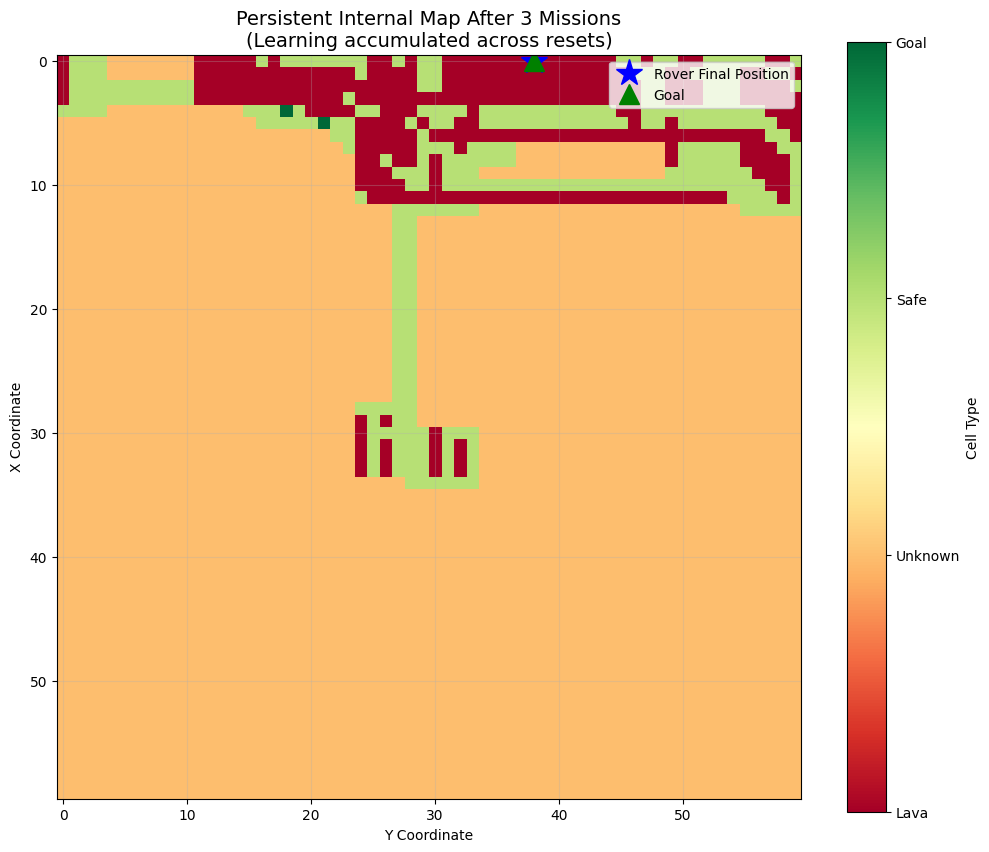


Map Statistics:
  🔥 Lava cells discovered: 290
  ✅ Safe cells explored: 305
  🎯 Goal cells marked: 2
  ❓ Unknown cells: 3003
  📊 Total cells mapped: 597



In [8]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class ModelBasedRover:
    def __init__(self, grid_size=60):
        """
        Initializes the agent with a large internal map.
        The internal_model persists across missions.
        """
        self.grid_size = grid_size
        # 0: Unknown, 1: Safe, -1: Hazard (Lava), 2: Goal
        self.internal_model = np.zeros((self.grid_size, self.grid_size))
        self.reset_agent_state()
        self.debug = False

    def reset_agent_state(self):
        """ Resets local tracking but NOT the internal_model. """
        self.curr_pos = [self.grid_size // 2, self.grid_size // 2]
        self.curr_dir = 0 # 0: Right, 1: Down, 2: Left, 3: Up
        self.step_count = 0
        self.goal_pos = None
        self.stuck_counter = 0
        self.last_positions = deque(maxlen=10)

    def update_model(self, obs_image):
        """
        obs_image: a 3D (7x7x3) partial view from the rover sensors
        """
        agent_obs_pos = [6, 3]
        
        for obs_row in range(7):
            for obs_col in range(7):
                dy = obs_row - agent_obs_pos[0]
                dx = obs_col - agent_obs_pos[1]
                
                # Rotate offset based on agent's current direction
                if self.curr_dir == 0:  # Facing Right
                    global_dx = -dy  
                    global_dy = dx   
                elif self.curr_dir == 1:  # Facing Down
                    global_dx = dx
                    global_dy = dy
                elif self.curr_dir == 2:  # Facing Left
                    global_dx = dy
                    global_dy = -dx
                elif self.curr_dir == 3:  # Facing Up
                    global_dx = -dx
                    global_dy = -dy
                
                global_x = self.curr_pos[0] + global_dx
                global_y = self.curr_pos[1] + global_dy
                
                if 0 <= global_x < self.grid_size and 0 <= global_y < self.grid_size:
                    obj_type = obs_image[obs_row, obs_col, 0]
                    
                    if obj_type == 9:  # Lava
                        self.internal_model[global_x, global_y] = -1
                    elif obj_type == 8:  # Goal
                        self.internal_model[global_x, global_y] = 2
                        self.goal_pos = (global_x, global_y)
                    elif obj_type in [1, 2]:  # Wall or floor
                        if self.internal_model[global_x, global_y] != -1:
                            self.internal_model[global_x, global_y] = 1

    def astar_pathfind(self, start, goal):
        """
        A* pathfinding using internal model.
        Returns path as list of positions, or None if no path exists.
        """
        def heuristic(a, b):
            return abs(a[0] - b[0]) + abs(a[1] - b[1])
        
        def get_neighbors(pos):
            neighbors = []
            for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nx, ny = pos[0] + dx, pos[1] + dy
                if (0 <= nx < self.grid_size and 
                    0 <= ny < self.grid_size):
                    # Allow movement to unknown (0), safe (1), or goal (2)
                    # Avoid lava (-1)
                    if self.internal_model[nx, ny] >= 0:
                        neighbors.append((nx, ny))
            return neighbors
        
        start_tuple = tuple(start)
        goal_tuple = tuple(goal)
        
        frontier = [(0, start_tuple)]
        came_from = {start_tuple: None}
        cost_so_far = {start_tuple: 0}
        
        while frontier:
            _, current = heapq.heappop(frontier)
            
            if current == goal_tuple:
                # Reconstruct path
                path = []
                while current is not None:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path
            
            for next_pos in get_neighbors(current):
                new_cost = cost_so_far[current] + 1
                
                if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                    cost_so_far[next_pos] = new_cost
                    priority = new_cost + heuristic(next_pos, goal_tuple)
                    heapq.heappush(frontier, (priority, next_pos))
                    came_from[next_pos] = current
        
        return None  # No path found

    def find_nearest_unexplored(self):
        """
        Find nearest unexplored (unknown) cell using BFS.
        """
        visited = set()
        queue = deque([tuple(self.curr_pos)])
        visited.add(tuple(self.curr_pos))
        
        while queue:
            current = queue.popleft()
            
            # Check if unexplored
            if self.internal_model[current[0], current[1]] == 0:
                return current
            
            # Explore neighbors
            for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nx, ny = current[0] + dx, current[1] + dy
                next_pos = (nx, ny)
                
                if (0 <= nx < self.grid_size and 
                    0 <= ny < self.grid_size and
                    next_pos not in visited and
                    self.internal_model[nx, ny] != -1):  # Not lava
                    
                    visited.add(next_pos)
                    queue.append(next_pos)
        
        return None

    def get_direction_to_neighbor(self, target):
        """
        Calculate which direction to turn/move to reach adjacent target.
        Returns action: 0=turn_left, 1=turn_right, 2=forward
        """
        dx = target[0] - self.curr_pos[0]
        dy = target[1] - self.curr_pos[1]
        
        # Determine target direction
        if dx == 1 and dy == 0:
            target_dir = 0  # Right
        elif dx == 0 and dy == 1:
            target_dir = 1  # Down
        elif dx == -1 and dy == 0:
            target_dir = 2  # Left
        elif dx == 0 and dy == -1:
            target_dir = 3  # Up
        else:
            # Not adjacent, just move forward
            return 2
        
        # Calculate turn needed
        turn = (target_dir - self.curr_dir) % 4
        
        if turn == 0:
            return 2  # Already facing correct direction
        elif turn == 1:
            return 1  # Turn right
        elif turn == 3:
            return 0  # Turn left (same as turning right 3 times)
        else:  # turn == 2
            return 1  # Turn right twice (do one turn now)

    def is_safe_cell(self, pos):
        """Check if a cell is safe to move to"""
        x, y = pos
        if not (0 <= x < self.grid_size and 0 <= y < self.grid_size):
            return False
        # Safe if unknown (0), safe (1), or goal (2)
        return self.internal_model[x, y] >= 0

    def get_front_cell(self):
        """Get the cell directly in front of the agent"""
        x, y = self.curr_pos
        if self.curr_dir == 0:  # Right
            return (x + 1, y)
        elif self.curr_dir == 1:  # Down
            return (x, y + 1)
        elif self.curr_dir == 2:  # Left
            return (x - 1, y)
        else:  # Up
            return (x, y - 1)

    def get_action(self, obs_image):
        """
        Advanced decision making with A* pathfinding and exploration.
        """
        self.step_count += 1
        self.last_positions.append(tuple(self.curr_pos))
        
        # Detect if stuck (repeating positions)
        if len(self.last_positions) == 10:
            unique_positions = len(set(self.last_positions))
            if unique_positions < 4:
                self.stuck_counter += 1
            else:
                self.stuck_counter = 0
        
        # Strategy 1: If goal is known, pathfind to it
        if self.goal_pos is not None:
            path = self.astar_pathfind(self.curr_pos, self.goal_pos)
            if path and len(path) > 1:
                next_cell = path[1]
                # Check if adjacent
                dist = abs(next_cell[0] - self.curr_pos[0]) + abs(next_cell[1] - self.curr_pos[1])
                if dist == 1 and self.is_safe_cell(next_cell):
                    return self.get_direction_to_neighbor(next_cell)
        
        # Strategy 2: Explore - find nearest unexplored area
        unexplored = self.find_nearest_unexplored()
        if unexplored is not None:
            path = self.astar_pathfind(self.curr_pos, unexplored)
            if path and len(path) > 1:
                next_cell = path[1]
                dist = abs(next_cell[0] - self.curr_pos[0]) + abs(next_cell[1] - self.curr_pos[1])
                if dist == 1 and self.is_safe_cell(next_cell):
                    return self.get_direction_to_neighbor(next_cell)
        
        # Strategy 3: If stuck, turn to break out of loop
        if self.stuck_counter > 5:
            self.stuck_counter = 0
            return 0  # Turn left to try different direction
        
        # Strategy 4: Simple wall-following - move forward if safe, else turn right
        front_cell = self.get_front_cell()
        if self.is_safe_cell(front_cell):
            return 2  # Move forward
        else:
            return 1  # Turn right

# ==========================================
# MAIN EXECUTION LOOP
# ==========================================
def run_mission():
    env = gym.make('MiniGrid-LavaGapS7-v0', render_mode='rgb_array')
    env = ImgObsWrapper(env)
    rover = ModelBasedRover()

    for mission in range(1, 4):
        obs, _ = env.reset()
        rover.reset_agent_state()
        print(f"\n{'='*60}")
        print(f"Starting Mission {mission}...")
        print(f"{'='*60}")

        terminated = False
        truncated = False
        steps = 0
        while not (terminated or truncated):
            rover.update_model(obs)
            action = rover.get_action(obs)

            # --- Synchronize internal tracker with chosen action ---
            if action == 0: 
                rover.curr_dir = (rover.curr_dir - 1) % 4
            elif action == 1: 
                rover.curr_dir = (rover.curr_dir + 1) % 4
            elif action == 2:
                if rover.curr_dir == 0: rover.curr_pos[0] += 1
                elif rover.curr_dir == 1: rover.curr_pos[1] += 1
                elif rover.curr_dir == 2: rover.curr_pos[0] -= 1
                elif rover.curr_dir == 3: rover.curr_pos[1] -= 1

            obs, reward, terminated, truncated, _ = env.step(action)
            steps += 1
            
            if steps > 1000:
                print(f"  Max steps reached...")
                truncated = True

            if terminated or truncated:
                result = '🎉 SUCCESS ✓' if reward > 0 else '❌ FAILED'
                print(f"Mission {mission} Result: {result}")
                print(f"  Steps taken: {steps}")
                if rover.goal_pos:
                    print(f"  Goal located at: {rover.goal_pos}")
                break

    # Visualization
    print(f"\n{'='*60}")
    print("FINAL INTERNAL MAP VISUALIZATION")
    print(f"{'='*60}")
    
    plt.figure(figsize=(12, 10))
    
    # Create custom colormap
    display_map = rover.internal_model.copy()
    
    plt.imshow(display_map, cmap='RdYlGn', interpolation='nearest', vmin=-1, vmax=2)
    plt.title("Persistent Internal Map After 3 Missions\n(Learning accumulated across resets)", fontsize=14)
    cbar = plt.colorbar(label='Cell Type', ticks=[-1, 0, 1, 2])
    cbar.ax.set_yticklabels(['Lava', 'Unknown', 'Safe', 'Goal'])
    
    # Mark rover's final position
    plt.plot(rover.curr_pos[1], rover.curr_pos[0], 'b*', markersize=20, label='Rover Final Position')
    
    # Mark goal if known
    if rover.goal_pos:
        plt.plot(rover.goal_pos[1], rover.goal_pos[0], 'g^', markersize=15, label='Goal')
    
    plt.legend(loc='upper right')
    plt.xlabel('Y Coordinate')
    plt.ylabel('X Coordinate')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Statistics
    lava_cells = np.count_nonzero(rover.internal_model == -1)
    safe_cells = np.count_nonzero(rover.internal_model == 1)
    goal_cells = np.count_nonzero(rover.internal_model == 2)
    unknown_cells = np.count_nonzero(rover.internal_model == 0)
    
    print(f"\nMap Statistics:")
    print(f"  🔥 Lava cells discovered: {lava_cells}")
    print(f"  ✅ Safe cells explored: {safe_cells}")
    print(f"  🎯 Goal cells marked: {goal_cells}")
    print(f"  ❓ Unknown cells: {unknown_cells}")
    print(f"  📊 Total cells mapped: {lava_cells + safe_cells + goal_cells}")
    print(f"\n{'='*60}")

if __name__ == "__main__":
    run_mission()

###  Utility-Based Agent: Autonomous Science Prioritization

UTILITY-BASED AGENT: Autonomous Science Prioritization

Rover starting mission at (0, 0)...
Available targets: 5
Mission: Collect 3 highest-utility targets


──────────────────────────────────────────────────────────────────────
DECISION ROUND 1
──────────────────────────────────────────────────────────────────────
Current position: (0, 0)

Evaluating remaining targets...
  Target (1, 8): Value=10, Cost=9.0, Utility=1.111
  Target (5, 5): Value=9, Cost=22.0, Utility=0.409
  Target (8, 1): Value=8, Cost=9.0, Utility=0.889
  Target (9, 9): Value=4, Cost=18.0, Utility=0.222
  Target (2, 2): Value=3, Cost=4.0, Utility=0.750

  ✓ SELECTED: (1, 8)
    - Scientific Value: 10
    - Energy Cost: 9.0
    - Utility Score: 1.111
    - Path length: 10 steps

──────────────────────────────────────────────────────────────────────
DECISION ROUND 2
──────────────────────────────────────────────────────────────────────
Current position: (1, 8)

Evaluating remaining targets...
  Target (5, 5): Value=9, C

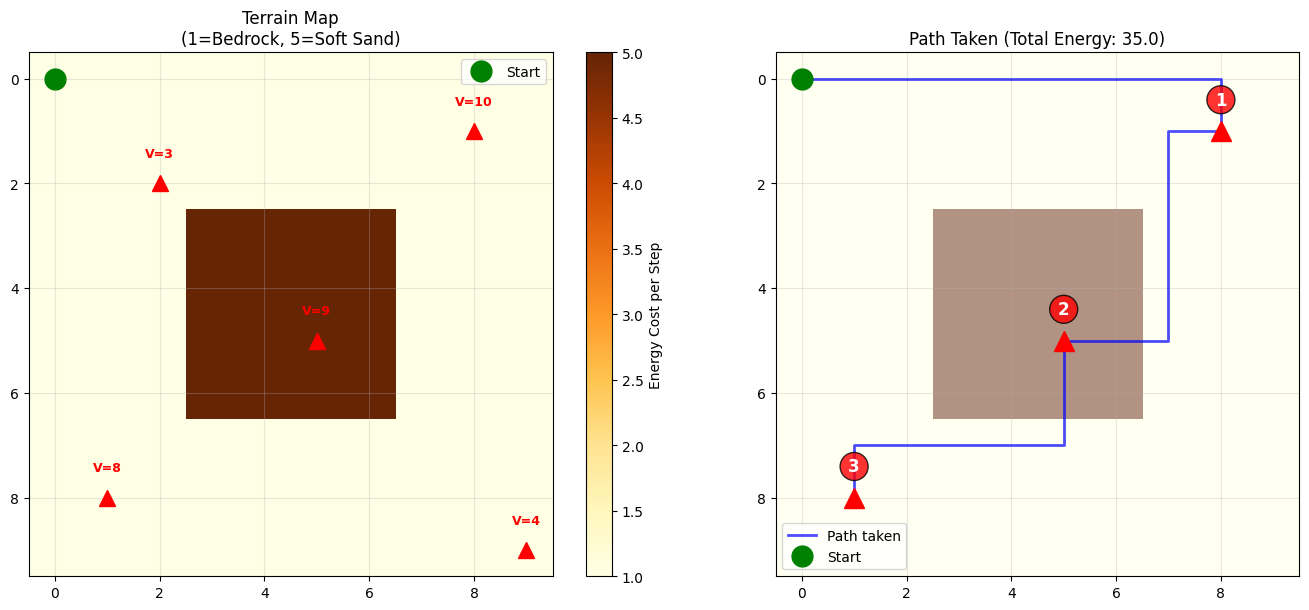


ANALYSIS: Utility Function Justification

The utility function U = Value / Cost was chosen to maximize efficiency.

Key Properties:
1. Value-per-Cost Ratio: Prioritizes targets with best return on investment
2. Naturally balances competing objectives without manual weight tuning
3. Scale-invariant: Works across different value/cost ranges

Example from this run:
- High-value target in soft sand might have LOWER utility than
  medium-value target on bedrock (due to 5x cost multiplier)
- This demonstrates rational decision-making: the agent avoids
  expensive detours even for high-value targets when more efficient
  options exist nearby

This embodies the core principle of utility-based agents: making
decisions that maximize expected utility given constraints.



In [9]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

def dijkstra_terrain(grid, start, goal):
    """
    Cost-sensitive Dijkstra's algorithm that minimizes terrain friction cost.
    
    Args:
        grid: 2D numpy array where each cell contains the energy cost per step
              (1 = bedrock, 5 = soft sand)
        start: (x, y) starting position
        goal: (x, y) goal position
    
    Returns:
        (path_list, total_friction_cost): 
            - path_list: List of (x,y) coordinates from start to goal
            - total_friction_cost: Sum of terrain costs along the path
    """
    rows, cols = grid.shape
    
    # Priority queue: (cost, position)
    frontier = [(0, start)]
    
    # Track best cost to reach each position
    cost_so_far = {start: 0}
    
    # Track path: came_from[pos] = previous_pos
    came_from = {start: None}
    
    while frontier:
        current_cost, current_pos = heapq.heappop(frontier)
        
        # Reached goal
        if current_pos == goal:
            # Reconstruct path
            path = []
            pos = goal
            while pos is not None:
                path.append(pos)
                pos = came_from[pos]
            path.reverse()
            
            return path, cost_so_far[goal]
        
        # Skip if we've already found a better path to this position
        if current_cost > cost_so_far.get(current_pos, float('inf')):
            continue
        
        # Explore 4-connected neighbors (up, down, left, right)
        x, y = current_pos
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            neighbor = (nx, ny)
            
            # Check bounds
            if 0 <= nx < rows and 0 <= ny < cols:
                # Cost to move to neighbor = current cost + terrain cost of neighbor cell
                new_cost = current_cost + grid[nx, ny]
                
                # If this path is better than any previous path to neighbor
                if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_cost
                    came_from[neighbor] = current_pos
                    heapq.heappush(frontier, (new_cost, neighbor))
    
    # No path found
    return [], float('inf')


def utility_fn(value, cost):
    """
    Utility function: Trade-off between scientific value and energy cost.
    
    Formula: U = Value / Cost
    
    Rationale:
    - Maximizes "value per unit of energy spent"
    - Naturally prioritizes high-value, low-cost targets
    - Avoids expensive targets unless their value justifies the cost
    - Dimensionless ratio (easy to compare across different scenarios)
    
    Alternative considered: U = Value - weight * Cost
    - Would require tuning weight parameter
    - Less intuitive (subtracting different units)
    
    Args:
        value: Scientific value of the target (1-10)
        cost: Energy cost to reach target (terrain-dependent)
    
    Returns:
        utility: Scalar utility score (higher = better choice)
    """
    if cost == 0:
        return float('inf')  # Free target = infinite utility
    
    return value / cost


# ==========================================
# MAIN EXECUTION BLOCK
# ==========================================
def run_mission_utility():
    # 1. Define the 10x10 Terrain (1: Bedrock, 5: Soft Sand)
    terrain = np.ones((10, 10))
    terrain[3:7, 3:7] = 5  # A large patch of sand in the middle
    
    # 2. Define Targets: { (x, y) : Scientific_Value }
    targets = {(1, 8): 10, (5, 5): 9, (8, 1): 8, (9, 9): 4, (2, 2): 3}
    
    current_pos = (0, 0)
    total_science = 0
    total_energy = 0
    visited_targets = []
    
    print("="*70)
    print("UTILITY-BASED AGENT: Autonomous Science Prioritization")
    print("="*70)
    print(f"\nRover starting mission at {current_pos}...")
    print(f"Available targets: {len(targets)}")
    print(f"Mission: Collect 3 highest-utility targets\n")
    
    # Visualize terrain
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Terrain map
    im1 = ax1.imshow(terrain, cmap='YlOrBr', interpolation='nearest')
    ax1.set_title('Terrain Map\n(1=Bedrock, 5=Soft Sand)', fontsize=12)
    ax1.plot(current_pos[1], current_pos[0], 'go', markersize=15, label='Start')
    for (tx, ty), val in targets.items():
        ax1.plot(ty, tx, 'r^', markersize=12)
        ax1.text(ty, tx-0.5, f'V={val}', ha='center', fontsize=9, color='red', weight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    plt.colorbar(im1, ax=ax1, label='Energy Cost per Step')
    
    # Collection order tracking
    visited_path = [current_pos]
    
    for i in range(3):  # Collect 3 targets
        print(f"\n{'─'*70}")
        print(f"DECISION ROUND {i+1}")
        print(f"{'─'*70}")
        print(f"Current position: {current_pos}")
        print(f"\nEvaluating remaining targets...")
        
        utilities = []
        for t_pos, val in targets.items():
            if t_pos in visited_targets:
                continue
            
            path, cost = dijkstra_terrain(terrain, current_pos, t_pos)
            u_score = utility_fn(val, cost)
            utilities.append((u_score, t_pos, cost, val, path))
            
            print(f"  Target {t_pos}: Value={val}, Cost={cost:.1f}, Utility={u_score:.3f}")
        
        # Select target with highest utility
        utilities.sort(key=lambda x: x[0], reverse=True)
        best_u, best_pos, best_cost, best_val, best_path = utilities[0]
        
        # Move Rover
        visited_targets.append(best_pos)
        visited_path.extend(best_path[1:])  # Add path (skip start since it's already there)
        current_pos = best_pos
        total_science += best_val
        total_energy += best_cost
        
        print(f"\n  ✓ SELECTED: {best_pos}")
        print(f"    - Scientific Value: {best_val}")
        print(f"    - Energy Cost: {best_cost:.1f}")
        print(f"    - Utility Score: {best_u:.3f}")
        print(f"    - Path length: {len(best_path)} steps")
    
    print(f"\n{'='*70}")
    print("MISSION COMPLETE")
    print(f"{'='*70}")
    print(f"Total Science Value Collected: {total_science}")
    print(f"Total Energy Spent: {total_energy:.1f}")
    print(f"Efficiency (Value/Energy): {total_science/total_energy:.3f}")
    print(f"Targets visited: {visited_targets}")
    print(f"{'='*70}\n")
    
    # Visualize path taken
    path_x = [p[1] for p in visited_path]
    path_y = [p[0] for p in visited_path]
    ax2.imshow(terrain, cmap='YlOrBr', interpolation='nearest', alpha=0.5)
    ax2.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.7, label='Path taken')
    ax2.plot(path_x[0], path_y[0], 'go', markersize=15, label='Start')
    
    # Mark visited targets
    for idx, target in enumerate(visited_targets):
        ax2.plot(target[1], target[0], 'r^', markersize=15)
        ax2.text(target[1], target[0]-0.5, f'{idx+1}', ha='center', 
                fontsize=12, color='white', weight='bold',
                bbox=dict(boxstyle='circle', facecolor='red', alpha=0.8))
    
    ax2.set_title(f'Path Taken (Total Energy: {total_energy:.1f})', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Justification Analysis
    print("\n" + "="*70)
    print("ANALYSIS: Utility Function Justification")
    print("="*70)
    print("""
The utility function U = Value / Cost was chosen to maximize efficiency.

Key Properties:
1. Value-per-Cost Ratio: Prioritizes targets with best return on investment
2. Naturally balances competing objectives without manual weight tuning
3. Scale-invariant: Works across different value/cost ranges

Example from this run:
- High-value target in soft sand might have LOWER utility than
  medium-value target on bedrock (due to 5x cost multiplier)
- This demonstrates rational decision-making: the agent avoids
  expensive detours even for high-value targets when more efficient
  options exist nearby

This embodies the core principle of utility-based agents: making
decisions that maximize expected utility given constraints.
""")
    print("="*70)

if __name__ == "__main__":
    run_mission_utility()